# LDE Project

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# model parameters
R_0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R_0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.31
delta_c = 1e-5
D_c = 1e-4
N = 60*1e6

# initial situation in Italy
S0 = 60.352*1e6
E0 = 1695
I0 = 308.8
R0 = 311.1
H0 = 127.4
D0 = 0
N0 = E0+I0+H0+R0+S0

thrsld = 1e-4

z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

In [3]:
# 1) permanent lockdown after reaching the threshold the first time

def myrate_hosp(t, r, t_thrsld):
    if t>=t_thrsld-1:    
        return r
    else:
        return 1
    
def mymodel_hosp(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H
    return [dS, dE, dI, dR, dH, dD]

## awareness/no awareness

In [4]:
t_max=250
t = np.arange(t_max)

# 1) PERMANENT LOCKDOWN
#at first, we look for time instant at which the hospitalized threshold for
#lockdown is reached, then we use it in a permanent lockdown model
t_thrsld=t_max+1

sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)

for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break

sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld))

S, E, I, R, H, D = sol.sol(t)
x = [S, E, I, R, H, D]

print(t_thrsld)

24


In [5]:
# no fear -> delta_c=10000

t_thrsld=t_max+1
sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S1, E1, I1, R1, H1, D1 = sol1.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break


sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 10000, k, nu, r, t_thrsld))

S1, E1, I1, R1, H1, D1 = sol1.sol(t)
x1 = [S1, E1, I1, R1, H1, D1]
print(t_thrsld)

24


In [6]:
import math as m

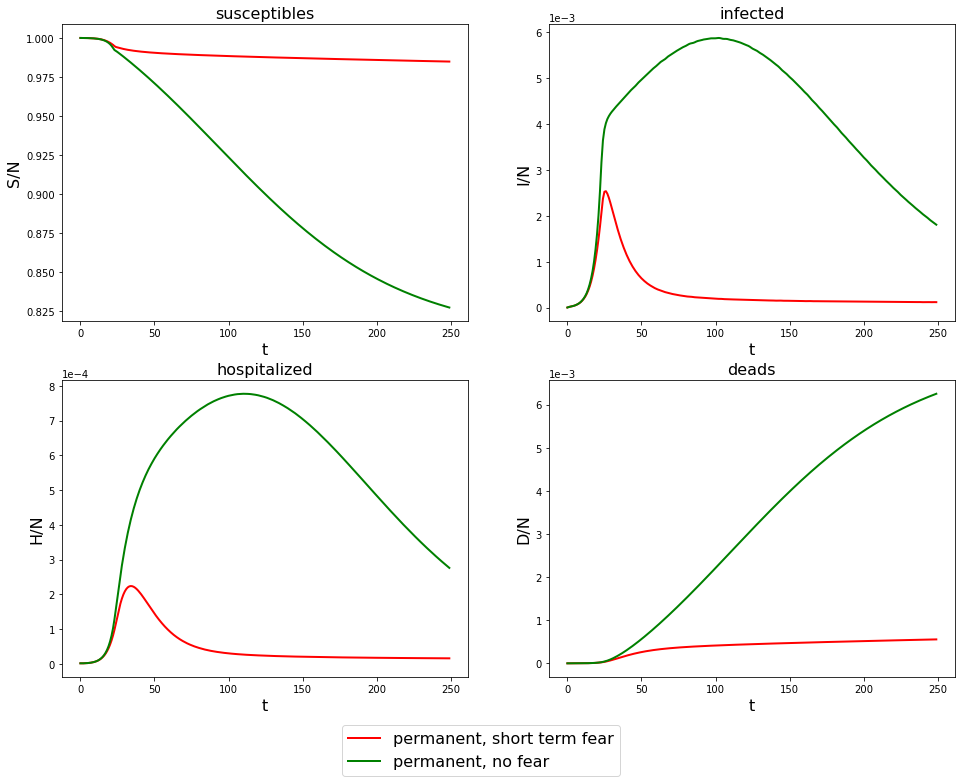

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))


z = [S, I, H, D]
z1 = [S1, I1, H1, D1]

names = ['susceptibles', 'infected', 'hospitalized', 'deads']
labels = ['S/N', 'I/N', 'H/N', 'D/N']
for i,(col,col1) in enumerate(zip(z, z1)):
    
    ax = axs[m.floor(i/2), i%2]
    ax.plot(t, col.T, color='red', lw=2)
    ax.plot(t, col1.T, color='green', lw=2)
    ax.set_xlabel('t', fontsize=16)
    ax.set_ylabel(labels[i], fontsize=16)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_title(names[i], fontsize=16)
    

fig.legend(['permanent, short term fear', 'permanent, no fear'],
                         loc='lower center', fontsize=16)
plt.savefig('permanent_VS_no_fear.png', dpi=300)
plt.show()

## $\beta_{eff}$ behaviour

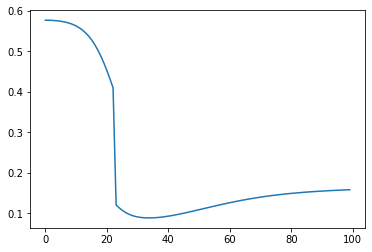

In [8]:
d_dot = D[1:]-D[:-1]


def beta_eff(beta, r, delta_c, k, d): 
    return ( beta * r ) / (1 + (d/delta_c)**k)


r_time = []
betas = []



for t in range(t_max-1):
    r_time.append(myrate_hosp(t, r, t_thrsld))
    betas.append(beta_eff(beta, r_time[t], delta_c, 1, d_dot[t]))
    

plt.plot(betas[:100])

## Parameter space: rate & $\delta_c$

In [9]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 41) 
rates = np.linspace(0.1, 1, 41)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        
        t_thrsld=t_max+1
        sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, 1, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        for index, h in enumerate(H):
            if (h>thrsld): 
                t_thrsld=index
                break
        
        sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        


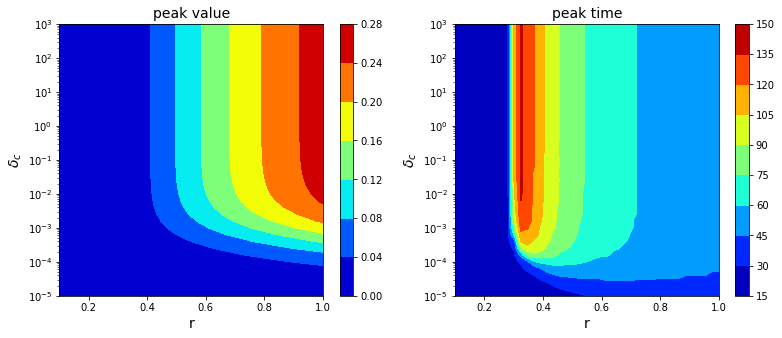

In [10]:
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13, 5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value', fontsize=14)
ax1.set_xlabel('r', fontsize=14)
ax1.set_ylabel(r'$\delta_c$', fontsize=14)
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time', fontsize=14)
ax2.set_xlabel('r', fontsize=14)
ax2.set_ylabel(r'$\delta_c$', fontsize=14)
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.savefig('permanent_peak_2D.png', dpi=300)
plt.show()

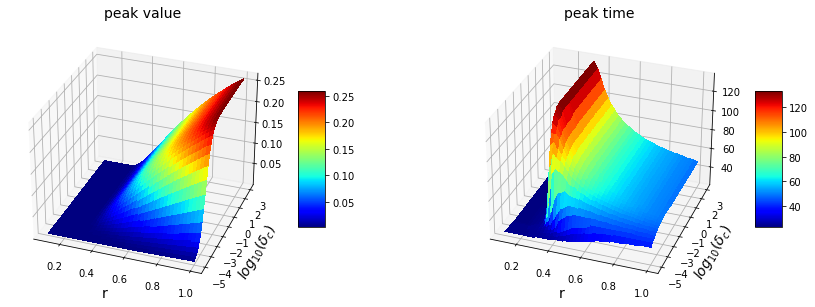

In [11]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log10(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  
ax1.set_title('peak value', fontsize=14)
ax1.set_xlabel('r', fontsize=14)
ax1.set_ylabel(r'$log_{10}(\delta_c)$', fontsize=14)

surf2 = ax2.plot_surface(X, np.log10(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time', fontsize=14)
ax2.set_xlabel('r', fontsize=14)
ax2.set_ylabel(r'$log_{10}(\delta_c)$', fontsize=14)

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.savefig('permanent_peak_3D.png', dpi=300)


plt.show()

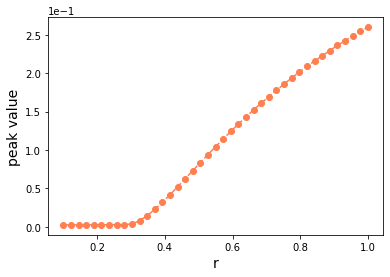

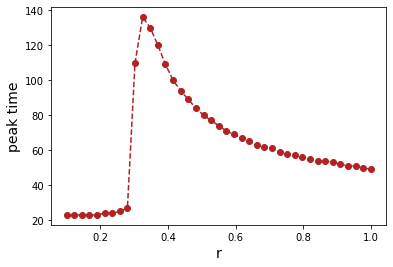

In [12]:
# fixed delta_c

plt.plot(rates, peak_values[20,:], 'o', color='coral', linestyle='--')
plt.xlabel('r', fontsize=14)
plt.ylabel('peak value', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig('fixed_delta_peak_value.png')
plt.show()

plt.plot(rates, peak_times[20,:], 'o', color='firebrick', linestyle='--')
plt.xlabel('r', fontsize=14)
plt.ylabel('peak time', fontsize=14)

#fig.suptitle(r'fixed $\delta_c = 0.1$', fontsize=14)
plt.savefig('fixed_delta_peak_time.png')
plt.show()

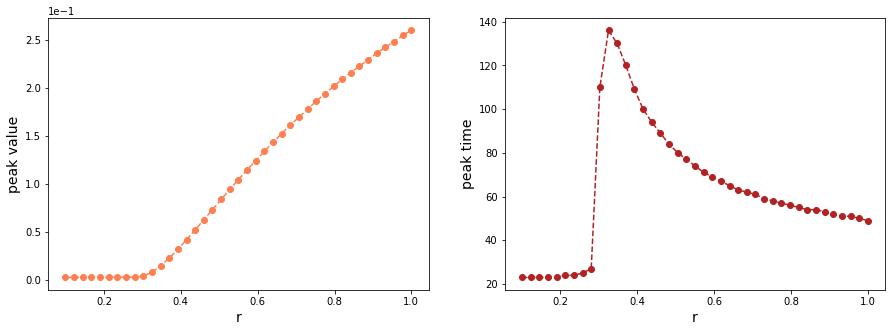

In [13]:
# fixed delta_c
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(rates, peak_values[20,:], 'o', color='coral', linestyle='--')
ax1.set_xlabel('r', fontsize=14)
ax1.set_ylabel('peak value', fontsize=14)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax2.plot(rates, peak_times[20,:], 'o', color='firebrick', linestyle='--')
ax2.set_xlabel('r', fontsize=14)
ax2.set_ylabel('peak time', fontsize=14)

#fig.suptitle(r'fixed $\delta_c = 0.1$', fontsize=14)
plt.savefig('fixed_delta_peak.png')
plt.show()

In [14]:
delta_c[20]

0.1

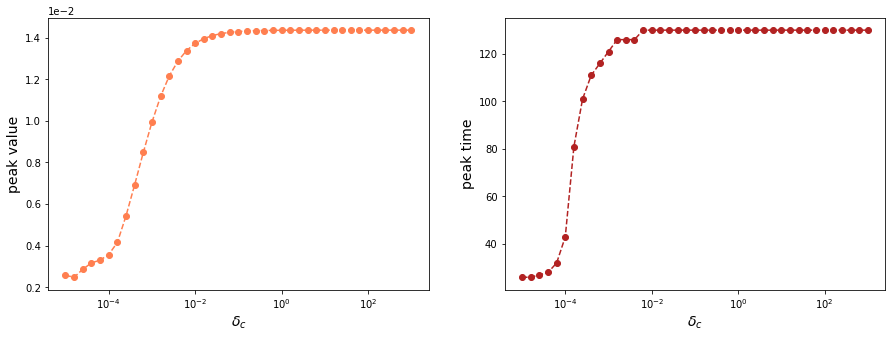

In [15]:
# fixed rate
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(delta_c, peak_values[:,11], 'o', color='coral', linestyle='--')
ax1.set_xscale('log')
ax1.set_xlabel(r'$\delta_c$', fontsize=14)
ax1.set_ylabel('peak value', fontsize=14)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax2.plot(delta_c, peak_times[:,11], 'o', color='firebrick', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$\delta_c$', fontsize=14)
ax2.set_ylabel('peak time', fontsize=14)

#fig.suptitle('fixed r = 0.35', fontsize=14)
plt.savefig('fixed_r_peak.png',dpi=300)
plt.show()

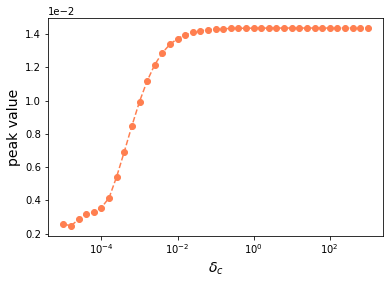

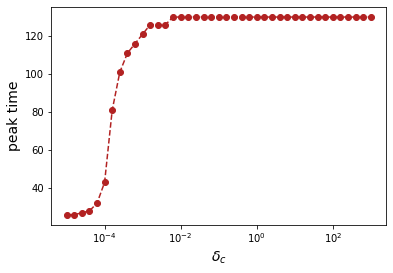

In [16]:
# fixed rate

plt.plot(delta_c, peak_values[:,11], 'o', color='coral', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\delta_c$', fontsize=14)
plt.ylabel('peak value', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig('fixed_r_peak_value.png',dpi=300)
plt.show()

plt.plot(delta_c, peak_times[:,11], 'o', color='firebrick', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\delta_c$', fontsize=14)
plt.ylabel('peak time', fontsize=14)

#fig.suptitle('fixed r = 0.35', fontsize=14)
plt.savefig('fixed_r_peak_time.png',dpi=300)
plt.show()

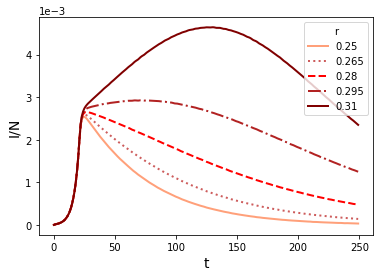

In [17]:
# infected dynamics
# changing rates
from matplotlib import cm

delta_c = 1e-1
rates = np.linspace(0.25, 0.31, 5)

Is = np.zeros(shape=(5, t_max))

t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break


for i,r in enumerate(rates):
    
   
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I

colors = ['lightsalmon', 'indianred', 'red', 'firebrick','maroon']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']

for i in range(5):
    plt.plot(t, Is[i], color=colors[i], linewidth=2, linestyle=linestyles[i])
    
plt.xlabel('t', fontsize=14)
plt.ylabel('I/N', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.title('incidence varying r', fontsize=14)
plt.legend(rates, title='r')
plt.savefig('incidence_varying_r.png', dpi=300)
plt.show()

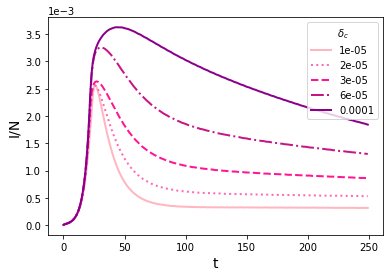

In [18]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 5)
rates = 0.35

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']
colors = ['lightpink', 'hotpink', 'deeppink', 'mediumvioletred', 'darkmagenta']

Is = np.zeros(shape=(5, t_max))
for i,delta in enumerate(delta_c):
    t_thrsld=t_max+1
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, 1, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    for index, h in enumerate(H):
        if (h>thrsld): 
            t_thrsld=index
            break
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
for i in range(5):
    plt.plot(t, Is[i], color=colors[i], linewidth=2, linestyle=linestyles[i])
plt.xlabel('t', fontsize=14)
plt.ylabel('I/N', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.title(r'incidence varying $\delta_c$', fontsize=14)
plt.legend(np.round(delta_c, 5), title=r'$\delta_c$')

plt.savefig('incidence_varying_delta.png', dpi=300)


plt.show()

## Parameter $k = 4$

Con $r<0.3$ il lockdown è troppo forte e la paura non conta più (collasso curve per k diversi). r=0.3 è il punto critico infatti\
Se la paura è poca se elevo a k, non influisce.\
osservare oscillazioni e plateau\
chiaramente se il lockdown è tanto forte ammazza completamente il termine paura e collassano le curve

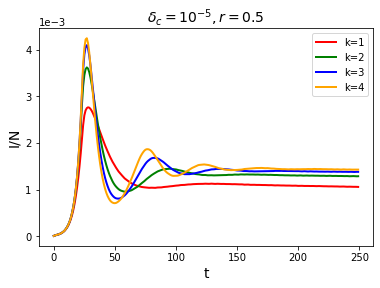

In [19]:
# caso tanta paura, lockdown non critico
d = 1e-5
rate = 0.5
ks = [1,2,3,4]


t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break

sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 1, nu, rate, t_thrsld))
I1 = sol1.sol(t)[2]
sol2 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 2, nu, rate, t_thrsld))
I2 = sol2.sol(t)[2]
sol3 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 3, nu, rate, t_thrsld))
I3 = sol3.sol(t)[2]
sol4 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 4, nu, rate, t_thrsld))
I4 = sol4.sol(t)[2]

plt.plot(t,I1, color = 'red', label='k=1', lw=2)
plt.plot(t,I2, color = 'green', label='k=2', lw=2)
plt.plot(t,I3, color = 'blue', label='k=3', lw=2)
plt.plot(t,I4, color = 'orange', label='k=4', lw=2)
plt.legend()
plt.xlabel('t', fontsize=14)
plt.ylabel('I/N', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'$\delta_c=10^{-5}, r=0.5$', fontsize=14)
plt.savefig('changing_k_1.png', dpi=300)
plt.show()

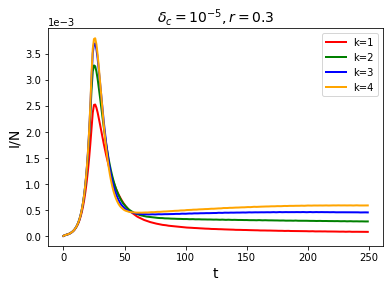

In [20]:
# caso tanta paura, lockdown non critico
d = 1e-5
rate = 0.3
ks = [1,2,3,4]


t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break



sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 1, nu, rate, t_thrsld))
I1 = sol1.sol(t)[2]
sol2 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 2, nu, rate, t_thrsld))
I2 = sol2.sol(t)[2]
sol3 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 3, nu, rate, t_thrsld))
I3 = sol3.sol(t)[2]
sol4 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 4, nu, rate, t_thrsld))
I4 = sol4.sol(t)[2]

plt.plot(t,I1, color = 'red', label='k=1', lw=2)
plt.plot(t,I2, color = 'green', label='k=2', lw=2)
plt.plot(t,I3, color = 'blue', label='k=3', lw=2)
plt.plot(t,I4, color = 'orange', label='k=4', lw=2)
plt.legend()
plt.xlabel('t', fontsize=14)
plt.ylabel('I/N', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'$\delta_c=10^{-5}, r=0.3$', fontsize=14)

plt.savefig('changing_k_2.png', dpi=300)

plt.show()

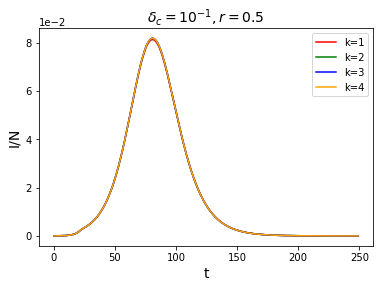

In [21]:
# caso poca paura, lockdown non critico
d = 1e-1
rate = 0.5
ks = [1,2,3,4]


t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break



sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 1, nu, rate, t_thrsld))
I1 = sol1.sol(t)[2]
sol2 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 2, nu, rate, t_thrsld))
I2 = sol2.sol(t)[2]
sol3 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 3, nu, rate, t_thrsld))
I3 = sol3.sol(t)[2]
sol4 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, 4, nu, rate, t_thrsld))
I4 = sol4.sol(t)[2]

plt.plot(t,I1, color = 'red', label='k=1')
plt.plot(t,I2, color = 'green', label='k=2')
plt.plot(t,I3, color = 'blue', label='k=3')
plt.plot(t,I4, color = 'orange', label='k=4')
plt.legend()
plt.xlabel('t', fontsize=14)
plt.ylabel('I/N', fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'$\delta_c=10^{-1}, r=0.5$', fontsize=14)

plt.savefig('changing_k_3.png', dpi=300)
plt.show()

## short/long term awareness

In [22]:
# 2) long term fear

def long_term_fear(t, z, beta, mu, gamma, fD, delta_c, D_c, k, nu, r, t_thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k + (D/D_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k + (D/D_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H   #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H  
    return [dS, dE, dI, dR, dH, dD]

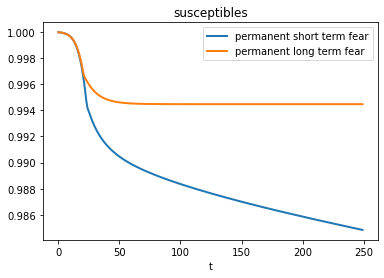

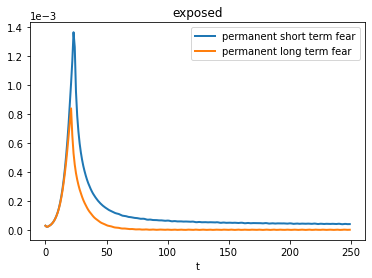

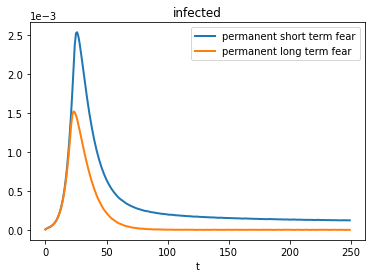

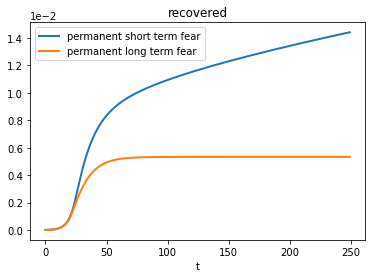

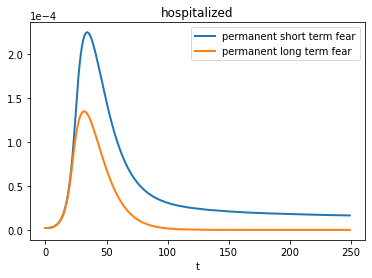

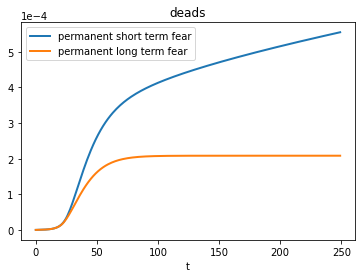

In [23]:
# 2) LONG TERM AWARENESS
k = 1
delta_c = 1e-5


t_thrsld=t_max+1
sol2 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S2, E2, I2, R2, H2, D2  = sol2.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break




sol2 = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, D_c, k, nu, r, t_thrsld))

S2, E2, I2, R2, H2, D2 = sol2.sol(t)
x2 = [S2, E2, I2, R2, H2, D2 ]

names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col2) in enumerate(zip(x, x2)):
    plt.figure(i)
    plt.plot(t, col.T, label = 'permanent short term fear', lw=2)
    plt.plot(t, col2.T, label = 'permanent long term fear', lw=2)
    plt.xlabel('t')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend()
    plt.title(names[i])

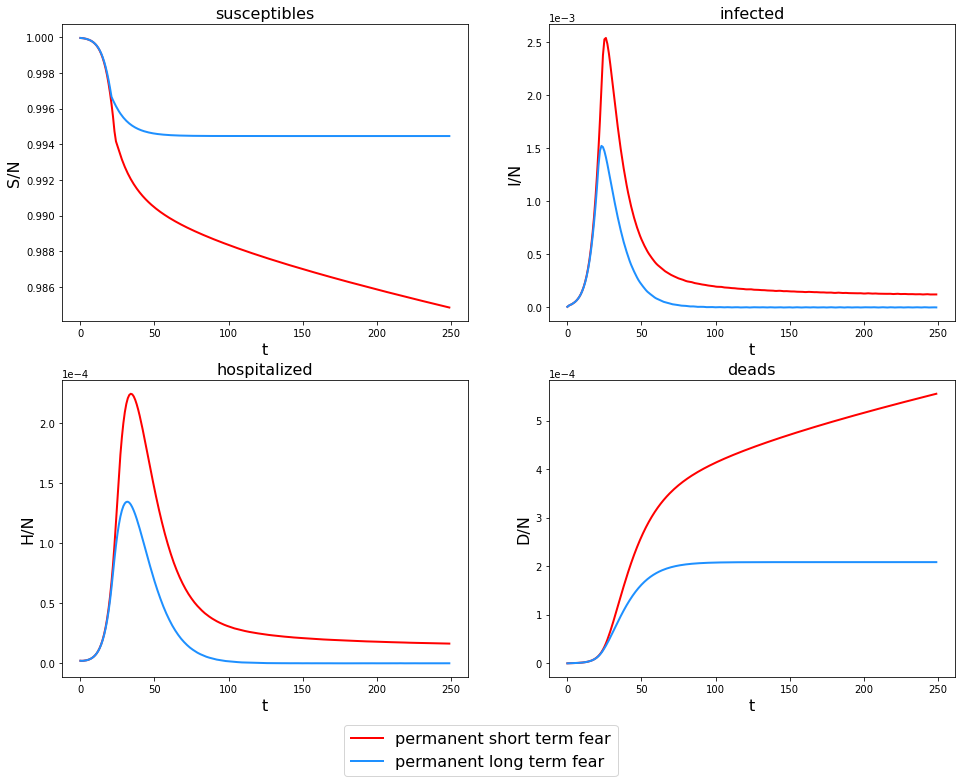

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))


z = [x[0], x[2], x[4], x[5]]
z2 = [S2, I2, H2, D2]

names = ['susceptibles', 'infected', 'hospitalized', 'deads']
labels = ['S/N', 'I/N', 'H/N', 'D/N']
for i,(col,col2) in enumerate(zip(z, z2)):
    
    ax = axs[m.floor(i/2), i%2]
    ax.plot(t, col.T, color='red', lw=2)
    ax.plot(t, col2.T, color='dodgerblue', lw=2)
    ax.set_xlabel('t', fontsize=16)
    ax.set_ylabel(labels[i], fontsize=16)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_title(names[i], fontsize=16)
    

fig.legend(['permanent short term fear', 'permanent long term fear'],
                         loc='lower center', fontsize=16)
plt.savefig('short_VS_long.png', dpi=300)
plt.show()

In [25]:
delta_c = np.logspace(-5, 3, 41) 
rates = np.linspace(0.1, 1, 41)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        
        t_thrsld=t_max+1
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c,  k, nu, 1, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        for index, h in enumerate(H):
            if (h>thrsld): 
                t_thrsld=index
                break
        
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        


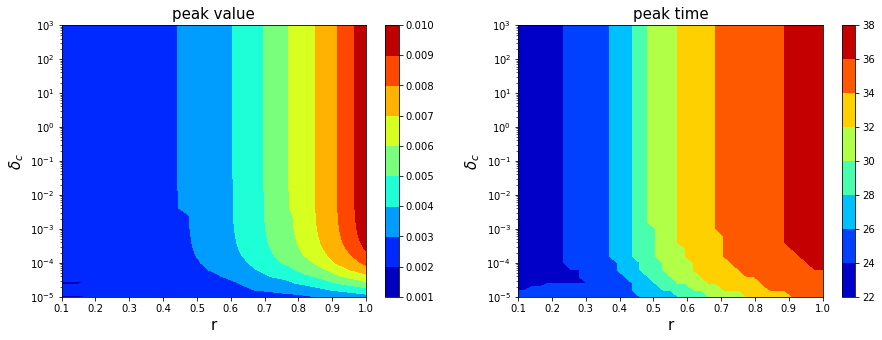

In [26]:
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value', fontsize=15)
ax1.set_xlabel('r', fontsize=15)
ax1.set_ylabel(r'$\delta_c$', fontsize=15)
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time', fontsize=15)
ax2.set_xlabel('r', fontsize=15)
ax2.set_ylabel(r'$\delta_c$', fontsize=15)
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.show()

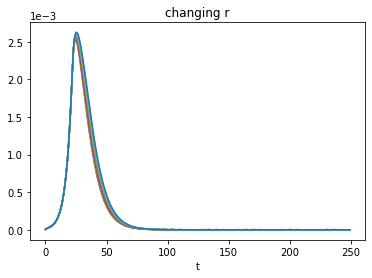

In [27]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))

t_thrsld=t_max+1
sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, D_c, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)
for index, h in enumerate(H):
    if (h>thrsld): 
        t_thrsld=index
        break


for i,r in enumerate(rates):
    
    
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, r, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('changing r')
plt.show()

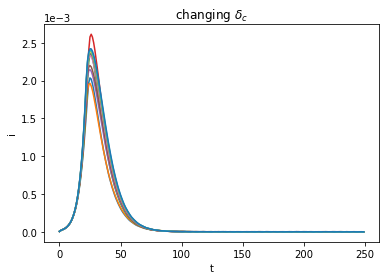

In [28]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    
    
    t_thrsld=t_max+1
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, 1, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    for index, h in enumerate(H):
        if (h>thrsld): 
            t_thrsld=index
            break
            
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, D_c, k, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.ylabel('i')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'changing $\delta_c$')
plt.show()

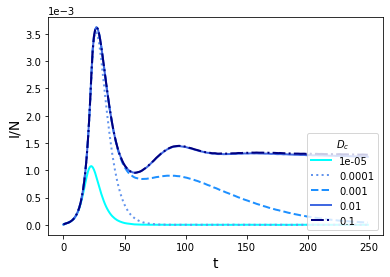

In [29]:
delta_c = 1e-5
rates = 0.5
D_cs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

Is = np.zeros(shape=(len(D_cs), t_max))
for i,DD in enumerate(D_cs):
    
    t_thrsld=t_max+1
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, DD,  k, nu, 1, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    for index, h in enumerate(H):
        if (h>thrsld): 
            t_thrsld=index
            break
    sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, DD, 2, nu, rates, t_thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I

colors = ['aqua', 'cornflowerblue', 'dodgerblue', 'royalblue', 'navy']
linestyles = ['solid', 'dotted', 'dashed',  'solid', 'dashdot']


    
for i in range(len(D_cs)):
    
    plt.plot(t,Is[i], color=colors[i], lw=2, ls=linestyles[i])
    plt.xlabel('t', fontsize=14)
    plt.ylabel('I/N', fontsize=14)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #plt.title(r'incidence varying $D_c$, $\delta=10^{-5}, r=0.5$', fontsize=14)
    
plt.legend(D_cs, loc='lower right', title=r'$D_c$')
plt.savefig('changing_D_c_1.png', dpi=300)

plt.show()

In [30]:
delta_c = np.logspace(-5, 3, 41) 
D_c = np.logspace(-5, 0, 41) 
r = 0.5

peak_times = np.zeros((len(delta_c), len(D_c)))
peak_values = np.zeros((len(delta_c), len(D_c)))

for i, delta in enumerate(delta_c):
    for j, dc in enumerate(D_c):
        
        t_thrsld=t_max+1
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, dc,  k, nu, 1, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        for index, h in enumerate(H):
            if (h>thrsld): 
                t_thrsld=index
                break
                
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, dc, k, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value

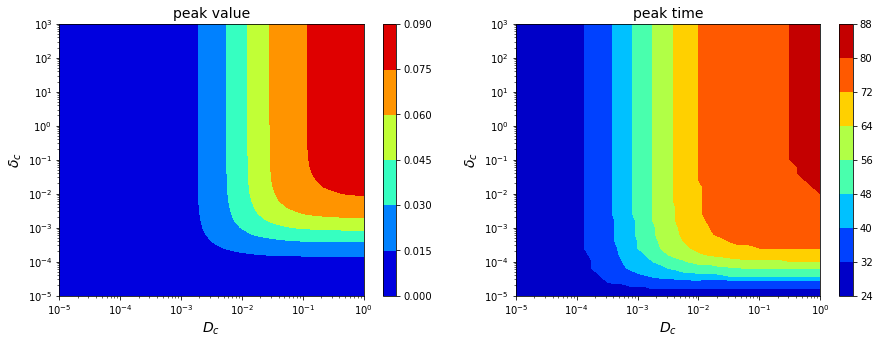

In [31]:
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(D_c, delta_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value', fontsize=14)
ax1.set_xlabel(r'$D_c$', fontsize=14)
ax1.set_xscale('log')
ax1.set_ylabel(r'$\delta_c$', fontsize=14)
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time', fontsize=14)
ax2.set_xlabel(r'$D_c$', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylabel(r'$\delta_c$', fontsize=14)
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.savefig('D_delta_2D.png', dpi=300)
plt.show()

In [32]:
delta_c = 1e-5
d_c = np.logspace(-5, 3, 41) 
rates = np.linspace(0.1, 1, 41)

peak_times = np.zeros((len(d_c), len(rates)))
peak_values = np.zeros((len(d_c), len(rates)))

for i, dc in enumerate(d_c):
    for j, r in enumerate(rates):
        t_thrsld=t_max+1
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, dc,  k, nu, 1, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        for index, h in enumerate(H):
            if (h>thrsld): 
                t_thrsld=index
                break
        sol = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, dc, k, nu, r, t_thrsld))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        

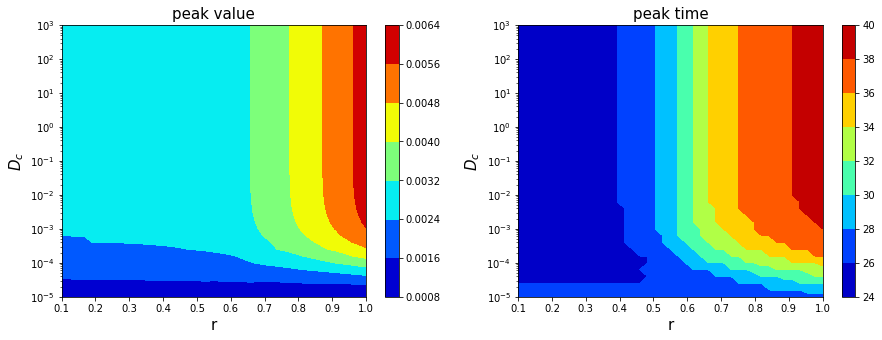

In [33]:
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, d_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value', fontsize=15)
ax1.set_xlabel('r', fontsize=15)
ax1.set_ylabel(r'$D_c$', fontsize=15)
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time', fontsize=15)
ax2.set_xlabel('r', fontsize=15)
ax2.set_ylabel(r'$D_c$', fontsize=15)
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.savefig('D_r_2D.png', dpi=300)


plt.show()

## permanent/intermittent lockdown

In [34]:
# model parameters
R_0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R_0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.3
delta_c = 1e-5
N = 60*1e6

# initial situation in Italy
S0 = 60.352*1e6
E0 = 1695
I0 = 308.8
R0 = 311.1
H0 = 127.4
D0 = 0
N0 = E0+I0+H0+R0+S0

thrsld =1e-4

z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

In [35]:
# 1) permanent lockdown after reaching the threshold the first time

def myrate_hosp(t, r, t_thrsld):
    if t>=t_thrsld-1:    
        return r
    else:
        return 1
    
def mymodel_hosp(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H
    return [dS, dE, dI, dR, dH, dD]

t = np.arange(t_max)

t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, t_eval = t, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, t_thrsld))
S, E, I, R, H, D = sol.sol(t)

index = t_max+1
for i, h in enumerate(H):
    if (h>thrsld): 
        index=i
        break
        
t_thrsld = index    
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, t_eval = t, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, t_thrsld))

S, E, I, R, H, D = sol.sol(t)
x = [S, E, I, R, H, D]

print(t_thrsld)

24


In [36]:
# 3) intermittent lockdown when reaching the threshold

def lockdown(H, r, thrsld):
    if H > thrsld:
        return r
    else:
        return 1

def lockdown_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, thrsld):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*lockdown(H, r, thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*lockdown(H, r, thrsld)/(1+(dD/delta_c)**k) - mu*E
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H
    dH = fD*gamma*I - gamma_H*H      
    return [dS, dE, dI, dR, dH, dD]

In [37]:
# 3) INTERMITTENT LOCKDOWN

sol3 = solve_ivp(lockdown_model, [0,t_max], z0, t_eval = t, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, thrsld))
S3, E3, I3, R3, H3, D3 = sol3.sol(t)
x3 = [S3, E3, I3, R3, H3, D3]

In [38]:
for i, h in enumerate(H3):
    if (h>thrsld): 
        index=i
        break

print(index)

24


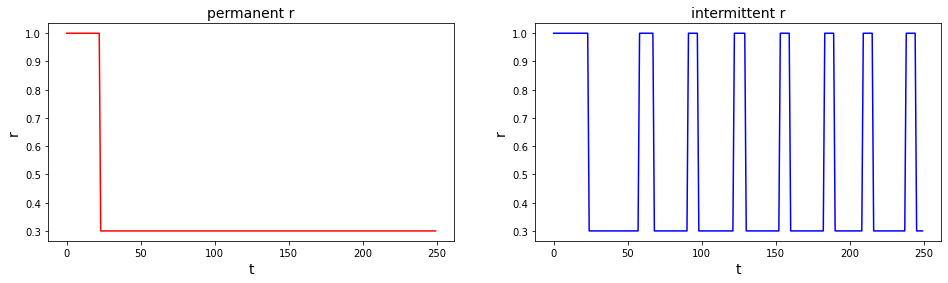

In [39]:
b1 = []
b2 = []
for i, h in zip(t, H3):
    b1.append(myrate_hosp(i, r, t_thrsld))
    b2.append(lockdown(h, r, thrsld))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(t, b1,'r-')
ax1.set_xlabel('t', fontsize=14)
ax1.set_ylabel('r', fontsize=14)
ax1.set_title('permanent r', fontsize=14)

ax2.plot(t, b2,'b-')
ax2.set_xlabel('t', fontsize=14)
ax2.set_ylabel('r', fontsize=14)
ax2.set_title('intermittent r', fontsize=14)

plt.savefig('rate',dpi=300)
plt.show()

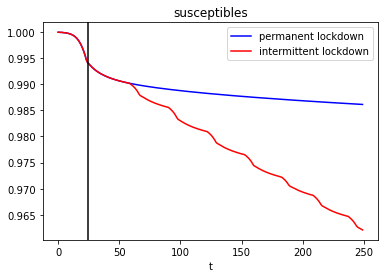

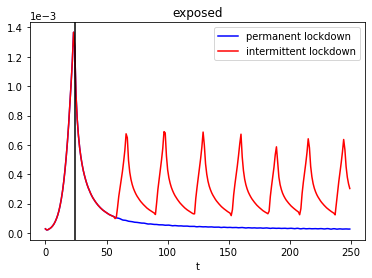

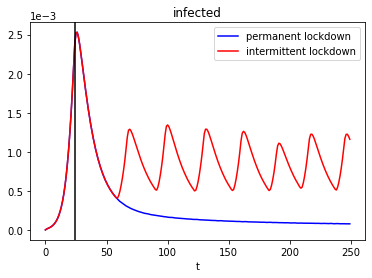

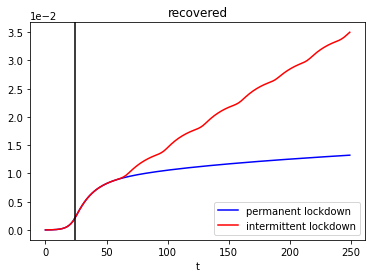

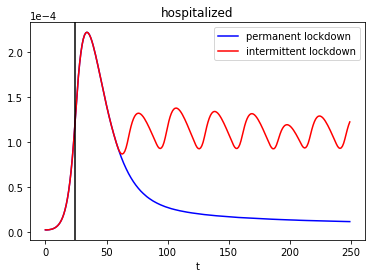

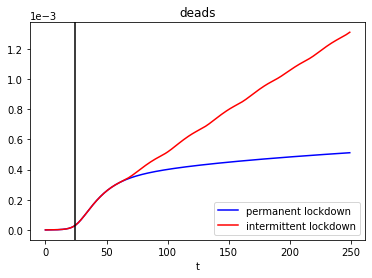

In [40]:
names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col3) in enumerate(zip(x, x3)):
    plt.figure(i)
    plt.plot(t, col.T, 'b', label = 'permanent lockdown')
    plt.plot(t, col3.T, 'r', label = 'intermittent lockdown')
    plt.axvline(t_thrsld, color='black')
    #plt.axhline(thrsld, color='black', alpha=0.5)
    plt.xlabel('t')
    #plt.xlim(0,50)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend()
    plt.title(names[i])

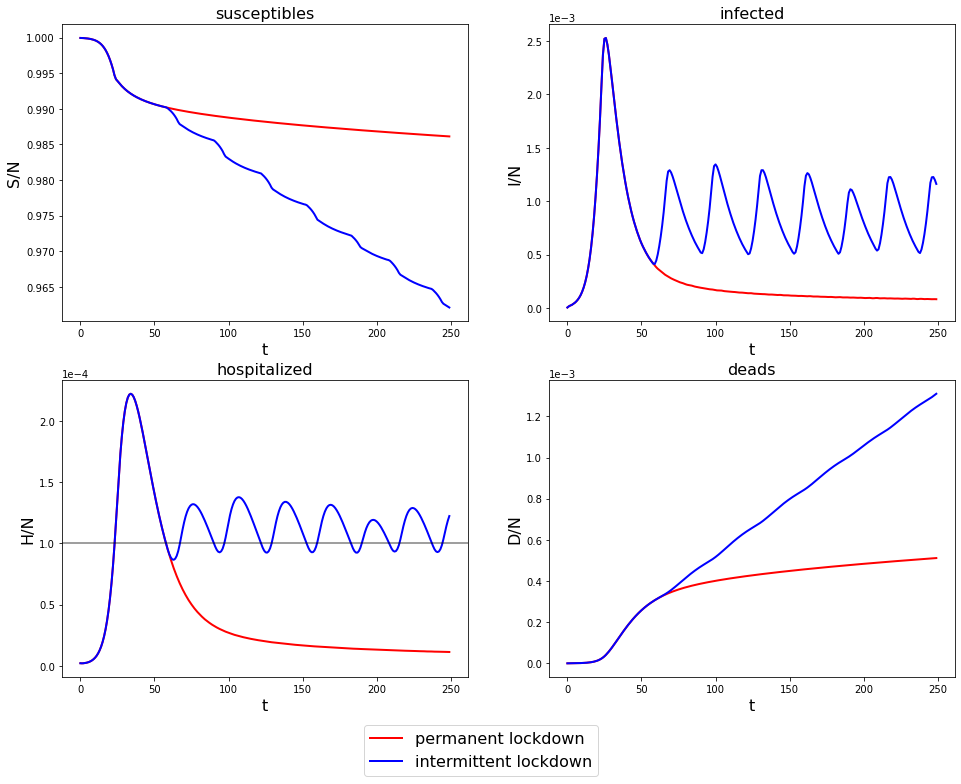

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))


z = [x[0], x[2], x[4], x[5]]
z3 = [S3, I3, H3, D3]

names = ['susceptibles', 'infected', 'hospitalized', 'deads']
labels = ['S/N', 'I/N', 'H/N', 'D/N']
for i,(col,col3) in enumerate(zip(z, z3)):
    
    ax = axs[m.floor(i/2), i%2]
    ax.plot(t, col.T, color='red', lw=2)
    ax.plot(t, col3.T, color='blue', lw=2)
    ax.set_xlabel('t', fontsize=16)
    ax.set_ylabel(labels[i], fontsize=16)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_title(names[i], fontsize=16)
    if (i==2):
        ax.axhline(thrsld, color='black', alpha=0.5)


    

fig.legend(['permanent lockdown', 'intermittent lockdown'],
                         loc='lower center', fontsize=16)
plt.savefig('intermittent_vs_permanent.png', dpi=300)
plt.show()

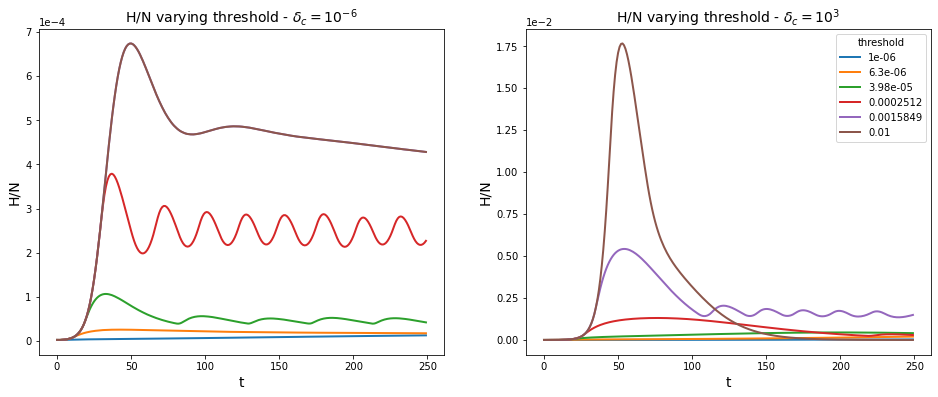

In [42]:
# change threshold
n_points = 6
thrsld_vctr = np.logspace(-6, -2, n_points)
Hs = np.zeros(shape=(n_points, t_max))
Hs1 = np.zeros(shape=(n_points, t_max))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i,thrsld in enumerate(thrsld_vctr):
    # with fear
    sol = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu,  0.31, thrsld))
    # without fear
    sol1 = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1000, k, nu,  0.31, thrsld))
    S, E, I, R, H, D = sol.sol(t)
    S1, E1, I1, R1, H1, D1 = sol1.sol(t)
    Hs[i,:]=H
    Hs1[i,:]=H1
    
    
ax = axs[0]   
ax.plot(t,Hs.T, lw=2)
ax.set_title(r'H/N varying threshold - $\delta_c=10^{-6}$', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('H/N', fontsize=14)
#ax.set_yscale('log')


ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax.legend(np.round(thrsld_vctr, 7))



ax = axs[1] 
ax.plot(t,Hs1.T,lw=2)
ax.set_title('H/N varying threshold - $\delta_c=10^{3}$', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('H/N', fontsize=14)
#ax.set_yscale('log')
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.legend(np.round(thrsld_vctr, 7), title='threshold')


plt.savefig('hospitalized_var_threshold.png', dpi=300)

plt.show()

Con paura non si va oltre 10^-5, quindi lockdown non scatta, ma vediamo il plateau\
Senza paura la dinamica è libera e spazia su diversi ordini di grandezza che vengono smorzati dal relativo lockdown

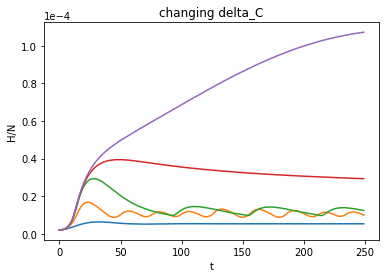

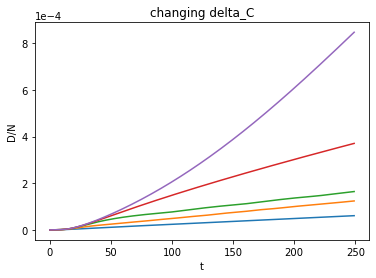

In [43]:
# change threshold
deltas = np.logspace(-7, -4, 5)
thrsld = 1e-5

Hs = np.zeros(shape=(5, t_max))
Ds = np.zeros(shape=(5, t_max))

for i,d in enumerate(deltas):
    sol = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, d, k, nu,  0.31, thrsld))
    S, E, I, R, H, D = sol.sol(t)
    Hs[i,:]=H
    Ds[i,:]=D

    
plt.plot(t,Hs.T)
plt.title('changing delta_C')
plt.xlabel('t')
plt.ylabel('H/N')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

plt.plot(t,Ds.T)
plt.title('changing delta_C')
plt.xlabel('t')
plt.ylabel('D/N')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

A causa della paura non superare mai soglia e quindi avere più morti, può capitare? Non succede, confronto curva arancione e blu, i morti cum sono meno nel caso non si superi mai la soglia


In [44]:
"""# total population plot
N = N0*(S+E+I+R+H)
N2 = N0*(S2+E2+I2+R2+H2)

plt.plot(t,N,label='1 step')
plt.plot(t,N2,label='2 step')
plt.title('total population')
plt.xlabel('t')
plt.legend()
plt.show()"""

"# total population plot\nN = N0*(S+E+I+R+H)\nN2 = N0*(S2+E2+I2+R2+H2)\n\nplt.plot(t,N,label='1 step')\nplt.plot(t,N2,label='2 step')\nplt.title('total population')\nplt.xlabel('t')\nplt.legend()\nplt.show()"